In [1]:
!pip install sunpy[all] lime

from IPython.display import clear_output
clear_output()

In [2]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
import pandas as pd
import scipy.stats
import requests
import urllib
import json
from datetime import datetime as dt_obj
from datetime import timedelta
from sklearn import svm
import lime
from sklearn.model_selection import StratifiedKFold
from sunpy.time import TimeRange
from sunpy.net import Fido, attrs as a

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
positive = pd.read_csv('/workspaces/flare-cme-association/2024/positive_2024.csv')
positive["CME"] = 1
negative = pd.read_csv('/workspaces/flare-cme-association/2024/negative_2024.csv')
negative["CME"] = 0

In [8]:
data = pd.concat([positive, negative],ignore_index=True)

In [9]:
data

,USFLUX,MEANGBT,MEANJZH,MEANPOT,SHRGT45,TOTUSJH,MEANGBH,MEANALP,MEANGAM,MEANGBZ,...,TOTPOT,MEANSHR,AREA_ACR,R_VALUE,ABSNJZH,HARPNUM,NOAA_ARS,GOES_Class,Peak_Time,CME
0,2.246101e+22,107.736,0.021724,15533.100,54.882,2975.118,77.983,0.041413,59.541,117.582,...,7.077275e+23,50.329,945.314636,4.805,745.287,377,11158,X2.2,2011.02.14_01:56_TAI,1
1,2.235615e+22,93.863,-0.001943,10914.060,44.178,1636.710,56.639,-0.003942,50.680,99.163,...,4.733711e+23,43.479,961.502686,4.303,63.441,401,11166,M2.0,2011.03.06_14:30_TAI,1
2,6.039302e+22,91.233,0.007535,9912.353,29.044,4229.148,49.560,0.015028,41.150,100.010,...,1.074422e+24,35.873,1934.446167,4.865,615.008,393,11164,M3.7,2011.03.06_20:12_TAI,1
3,2.384940e+22,109.706,0.009620,3703.910,13.500,1505.331,47.602,0.030907,34.321,110.939,...,1.879337e+23,28.525,970.551636,3.971,367.530,637,11226,M2.5,2011.06.06_06:41_TAI,1
4,1.989983e+22,109.891,0.032849,12062.610,44.090,2547.054,73.681,0.079865,53.270,115.866,...,5.269515e+23,43.929,1259.099854,4.777,1080.528,750,11261,M6.0,2011.08.02_13:48_TAI,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,1.249151e+23,112.155,-0.002390,10825.290,28.936,9091.145,56.414,-0.004075,41.643,119.929,...,2.170356e+24,34.840,8459.094727,5.062,360.843,12094,13869,M1.2,2024.10.27_14:44_TAI,0
1035,1.081189e+23,109.247,-0.003565,10536.930,31.711,7737.148,56.151,-0.006695,43.762,115.667,...,1.971573e+24,36.673,7948.322266,4.961,502.214,12094,13873,M1.1,2024.10.28_16:33_TAI,0
1036,6.244102e+22,77.040,-0.023672,19092.970,31.367,4295.733,43.265,-0.031920,41.071,84.909,...,1.720882e+24,35.413,2649.689941,4.887,1606.504,12160,13878,M7.2,2024.10.29_20:53_TAI,0
1037,6.870547e+22,79.695,-0.019042,17385.150,30.879,4611.801,41.817,-0.027868,40.930,86.393,...,1.821178e+24,35.454,2678.618408,4.751,1501.977,12160,13878,M1.3,2024.10.30_09:37_TAI,0


## Plotting histograms to see the variability of the data

In [10]:
positive.head()

,USFLUX,MEANGBT,MEANJZH,MEANPOT,SHRGT45,TOTUSJH,MEANGBH,MEANALP,MEANGAM,MEANGBZ,...,TOTPOT,MEANSHR,AREA_ACR,R_VALUE,ABSNJZH,HARPNUM,NOAA_ARS,GOES_Class,Peak_Time,CME
0,2.246101e+22,107.736,0.021724,15533.100,54.882,2975.118,77.983,0.041413,59.541,117.582,...,7.077275e+23,50.329,945.314636,4.805,745.287,377,11158,X2.2,2011.02.14_01:56_TAI,1
1,2.235615e+22,93.863,-0.001943,10914.060,44.178,1636.710,56.639,-0.003942,50.680,99.163,...,4.733711e+23,43.479,961.502686,4.303,63.441,401,11166,M2.0,2011.03.06_14:30_TAI,1
2,6.039302e+22,91.233,0.007535,9912.353,29.044,4229.148,49.560,0.015028,41.150,100.010,...,1.074422e+24,35.873,1934.446167,4.865,615.008,393,11164,M3.7,2011.03.06_20:12_TAI,1
3,2.384940e+22,109.706,0.009620,3703.910,13.500,1505.331,47.602,0.030907,34.321,110.939,...,1.879337e+23,28.525,970.551636,3.971,367.530,637,11226,M2.5,2011.06.06_06:41_TAI,1
4,1.989983e+22,109.891,0.032849,12062.610,44.090,2547.054,73.681,0.079865,53.270,115.866,...,5.269515e+23,43.929,1259.099854,4.777,1080.528,750,11261,M6.0,2011.08.02_13:48_TAI,1


In [12]:
data = data.drop(['HARPNUM','NOAA_ARS','GOES_Class','Peak_Time'], axis=1)

<Axes: >

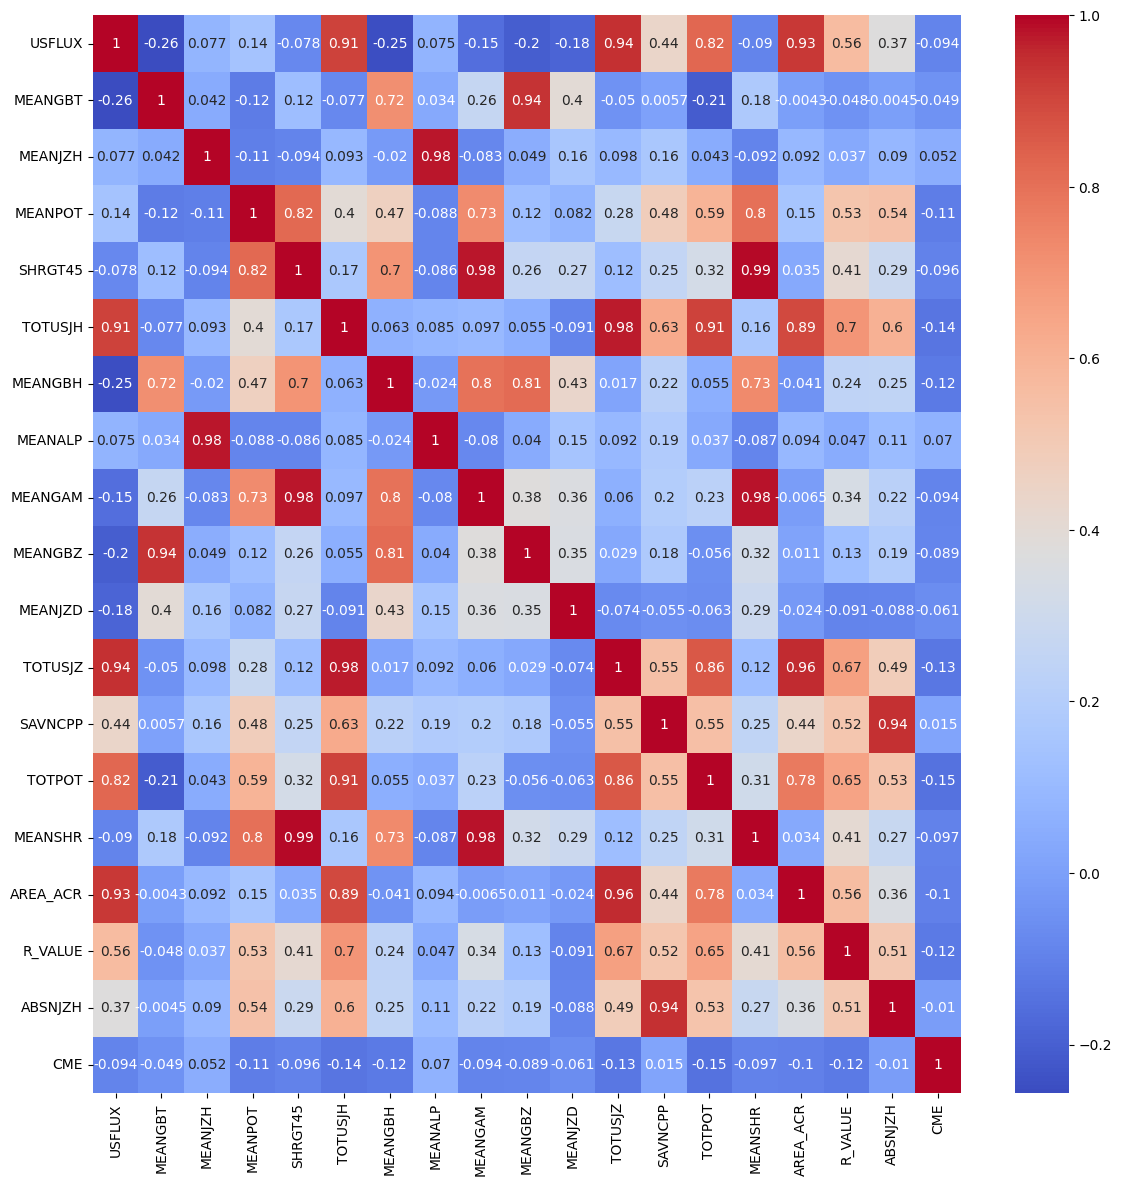

In [13]:
import seaborn as sns
plt.figure(figsize=(14,14))
sns.heatmap(data.corr(),annot=True,cmap="coolwarm")

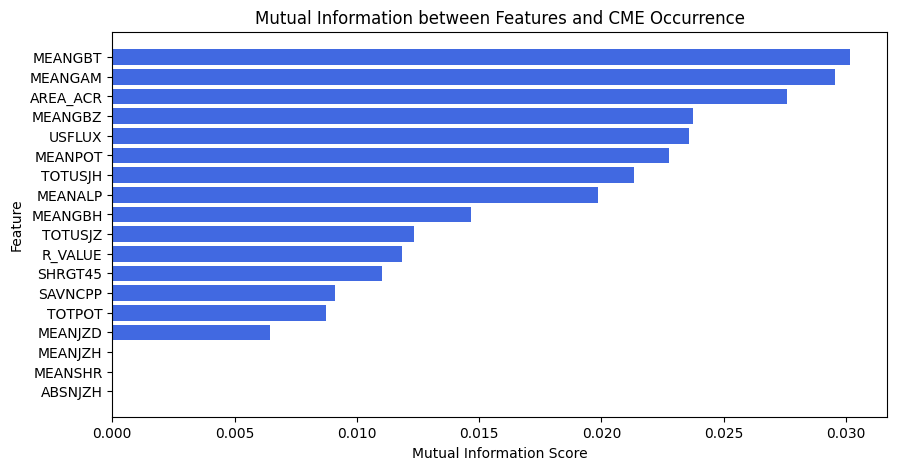

     Feature  MI Score
1    MEANGBT  0.030176
8    MEANGAM  0.029555
15  AREA_ACR  0.027599
9    MEANGBZ  0.023761
0     USFLUX  0.023580
3    MEANPOT  0.022781
5    TOTUSJH  0.021338
7    MEANALP  0.019842
6    MEANGBH  0.014656
11   TOTUSJZ  0.012333
16   R_VALUE  0.011832
4    SHRGT45  0.011027
12   SAVNCPP  0.009119
13    TOTPOT  0.008730
10   MEANJZD  0.006453
2    MEANJZH  0.000000
14   MEANSHR  0.000000
17   ABSNJZH  0.000000


In [15]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

X = data.drop(columns=['CME'])
y = data['CME']

# Normalize features (recommended for MI computation)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Compute Mutual Information scores
mi_scores = mutual_info_classif(X_scaled, y, random_state=42)

# Convert to a DataFrame for easy visualization
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by="MI Score", ascending=False)

# Plot results
plt.figure(figsize=(10, 5))
plt.barh(mi_df['Feature'], mi_df['MI Score'], color="royalblue")
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.title("Mutual Information between Features and CME Occurrence")
plt.gca().invert_yaxis()  # Highest MI at the top
plt.show()

# Print top MI scores
print(mi_df)

In [16]:
datami = data.drop(["MEANGBZ","MEANSHR","MEANJZD","ABSNJZH","MEANJZH","TOTUSJH","SHRGT45"],axis = 1)

<Axes: >

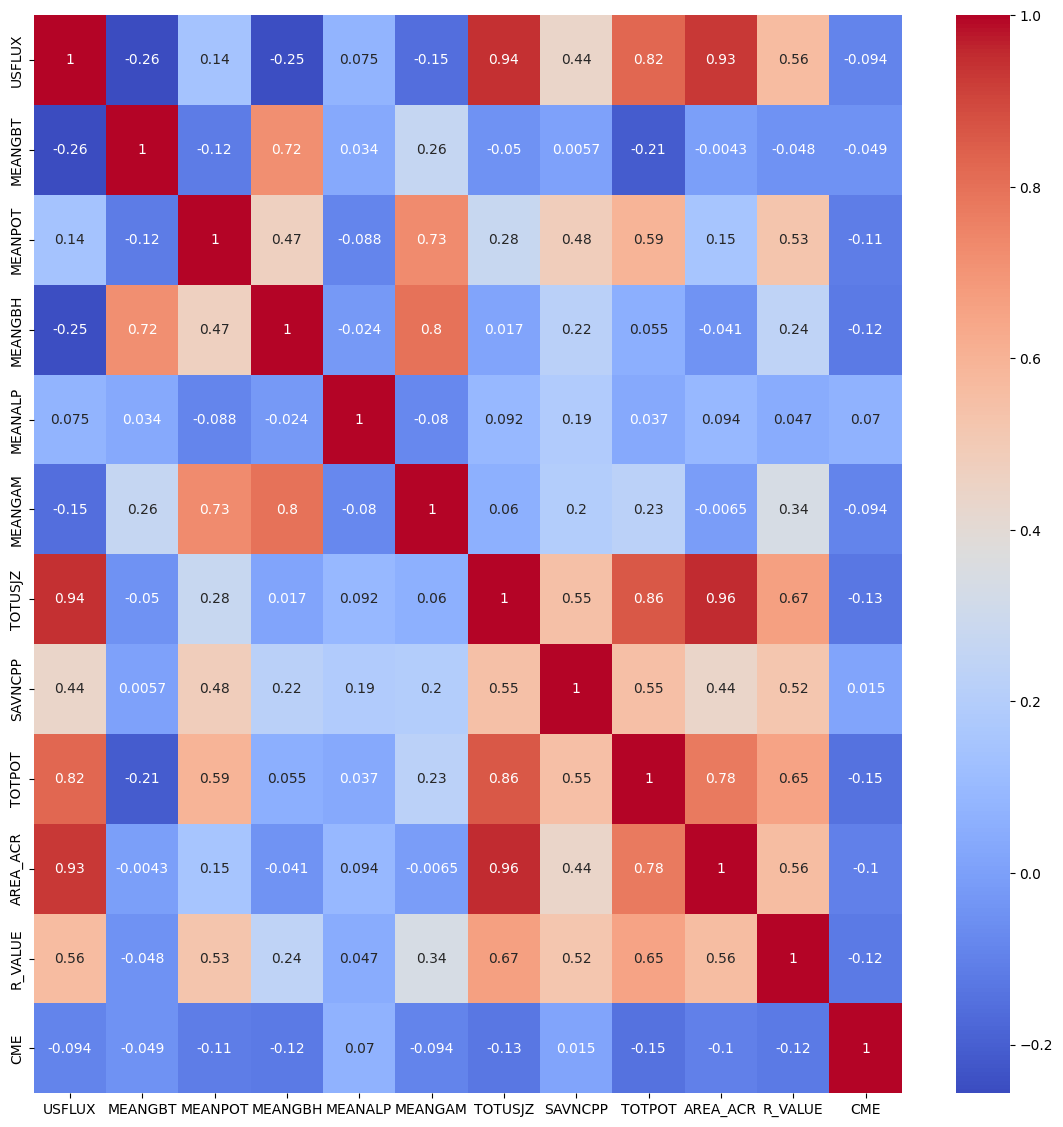

In [17]:
import seaborn as sns
plt.figure(figsize=(14,14))
sns.heatmap(datami.corr(),annot=True,cmap="coolwarm")

## Logistic Regression


In [18]:
datami.describe()

,USFLUX,MEANGBT,MEANPOT,MEANGBH,MEANALP,MEANGAM,TOTUSJZ,SAVNCPP,TOTPOT,AREA_ACR,R_VALUE,CME
count,1.039000e+03,1039.000000,1039.000000,1039.000000,1039.000000,1039.000000,1.039000e+03,1.039000e+03,1.039000e+03,1039.000000,1039.000000,1039.000000
mean,5.622256e+22,98.789760,10073.150908,56.209888,0.001305,45.370914,8.382929e+13,2.644055e+13,1.137211e+24,2328.623689,4.722002,0.274302
std,4.259561e+22,14.145924,4695.308109,12.354946,0.028903,7.558424,5.935984e+13,2.661340e+13,9.935806e+23,1795.312079,0.566411,0.446377
min,8.884723e+20,57.317000,800.379700,24.736000,-0.101044,22.653000,1.954238e+12,6.315266e+11,6.820719e+21,33.391842,0.000000,0.000000
25%,2.587617e+22,90.296000,6418.744000,47.399000,-0.015150,39.933500,4.119031e+13,7.556948e+12,4.268193e+23,1131.610901,4.459000,0.000000
50%,4.527543e+22,99.936000,9524.636000,55.463000,0.000173,45.492000,7.008560e+13,1.669001e+13,9.188106e+23,1822.082153,4.801000,0.000000
75%,7.142977e+22,108.496500,13043.360000,65.385500,0.016327,51.392000,1.064974e+14,3.555582e+13,1.479392e+24,3063.420410,5.058000,1.000000
max,2.499619e+23,147.131000,26768.320000,95.375000,0.108773,61.987000,3.420606e+14,1.313671e+14,5.276354e+24,10627.308594,5.739000,1.000000


In [28]:
from sklearn.model_selection import train_test_split

X = datami.drop(columns=['CME'])
y = datami['CME']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = LogisticRegression(class_weight="balanced",random_state=42)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5576923076923077


In [31]:
TP, FP, FN, TN = confusion_matrix(y_test, y_pred).ravel()
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))

TSS = (TP / (TP + FN)) - (FP / (FP + TN))
print(TSS)

Confusion Matrix:
[[76 75]
 [17 40]]
0.1650303880317906


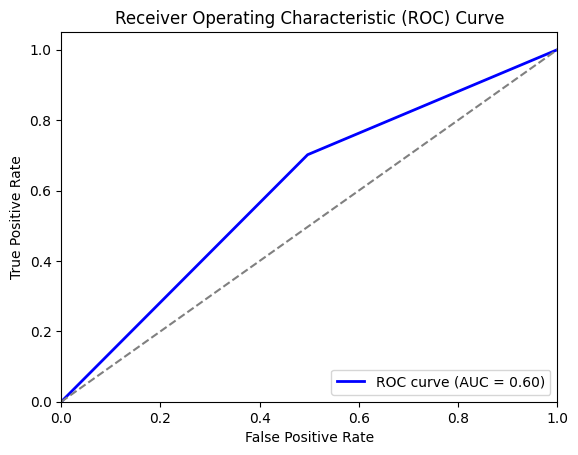

In [32]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Random Forest

In [33]:
from sklearn.model_selection import train_test_split

X = datami.drop(columns=['CME'])
y = datami['CME']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)

In [34]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for ROC curve

# Compute metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
TP, FP, FN, TN = confusion_matrix(y_test, y_pred_rf).ravel()
TSS_rf = (TP / (TP + FN)) - (FP / (FP + TN))

print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print(f"Random Forest TSS: {TSS_rf:.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Accuracy: 0.68
Random Forest TSS: 0.12
Confusion Matrix:
[[129  22]
 [ 44  13]]


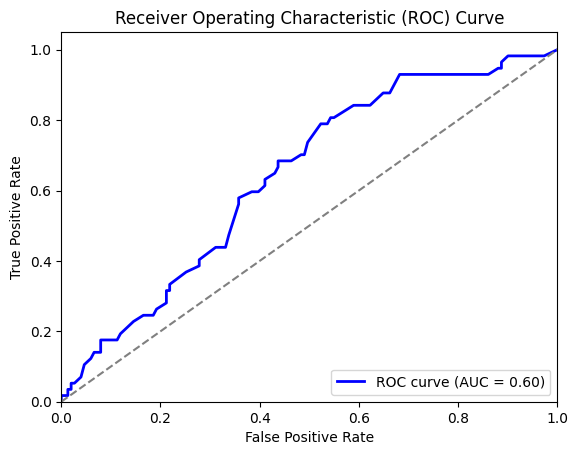

In [37]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()